In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tire
import car
from scipy.optimize import newton
con = 180/np.pi
from numpy import linalg

Roll axis inclination: 1.43 deg
Unsprung CG height from roll axis: 0.17 m
Roll sensitivity: -0.50 deg/g
Front lateral weight transfer: 174.81 N/g
Rear lateral weight transfer:  324.43 N/g
Longitudinal weight transfer:       399.74 N/g
Front static wheel load:            -668.60 N
Rear static wheel load:             -665.40 N
Total weight:     -2668.00 N


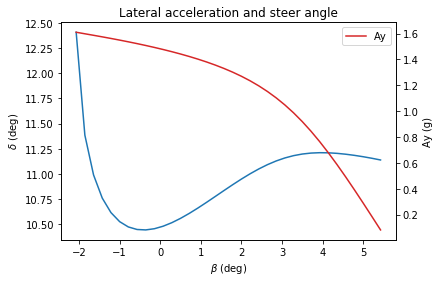

In [2]:
params = {
    'W_uf' : 111,    #Front unsprung weight (N)
    'W_ur' : 111,    #Rear unsprung weight  (N)
    'W_s'  : 2446,   #Sprung weight         (N)
    # CG locations
    'z_wf' : 0.21,   #Front unsprung height (m)
    'z_wr' : 0.21,   #Rear unsprung height  (m)
    'h_s'  : 0.23,   #Sprung height         (m)
    'a_s'  : 0.76,   #Sprung distance from front axle (m)
    # Car geometry
    'l'    : 1.524,  #Wheelbase   (m)
    't_f'  : 1.22,   #Front track (m)
    't_r'  : 1.22,   #Rear track  (m)
    # Roll center heights
    'z_rf' : 0.038,  #Front roll center height (m)
    'z_rr' : 0.076,  #Rear roll center height  (m)
    # Roll rates
    'K_f'  : 16.5e3, #Front roll rate (N-m/rad)
    'K_r'  : 32e3, #Rear roll rate  (N-m/rad)
    # Steering
    'ack'  : 0.0,    #Steering Ackerman (%)
    'toe_f': 0.5,   #Front toe (deg)
    'toe_r': 1.5,    #Rear toe  (deg)
    'tire' : tire.Hoosier10X7()
}
C = car.Car(params)
N = 50
r = 8
beta = np.linspace(-2.5, 8, N)
beta *= 1/con
delta = np.zeros(N, dtype='double')
Ay = np.zeros(N, dtype='double')
Fx = np.zeros(N, dtype='double')
load = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
KA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
SA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
F = {}
FE = {}
for i in range(N):
    delta[i] = C.get_delta(r, beta[i])
    Ay[i], Fx[i], load[i], KA[i], SA[i], F[i], FE[i] = C.Ay_Fx_from_angle(r, beta[i], delta[i], extra=True)
# Strip nans from the array
sel = np.invert(np.isnan(Ay))
sel2 = Ay[sel] > 0
plt.plot(beta[sel][sel2]*con, delta[sel][sel2]*con, 'tab:blue')
plt.title('Lateral acceleration and steer angle')
plt.xlabel(r'$\beta$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.twinx()
plt.plot(beta[sel][sel2]*con, Ay[sel][sel2], 'tab:red')
plt.ylabel(r'Ay (g)')
plt.legend([r'Ay'])
plt.show()

In [3]:
# Show the tire data at peak lateral acceleration
betaM = beta[sel][0]
deltaM = delta[sel][0]
AyM, FxM, loadM, KAM, SAM, FM, FEM = C.Ay_Fx_from_angle(r, betaM, deltaM, extra=True)
SAP = C.calc_peak_slip_angles(loadM)
FCM = C.get_chassis_tire_forces(FM, KAM, betaM)
MzM = C.calc_yaw_moment(FCM)
C.print_force_info(AyM, betaM, deltaM, MzM, KAM, SAM, SAP, loadM, FM, FEM, FCM)

Values at the maximum
---------------------------------------------------------------------
Ay:              1.61 g
Beta:            -2.07 deg
Delta:           12.41 deg
Mz:              -0.00 N-m

Wheel parameters             FR          FL          RR          RL
---------------------------------------------------------------------
Kin angle (deg):         -13.98,     -14.98,      -0.57,      -3.57
Slip angle (deg):         -8.26,      -9.78,      -6.62,      -8.48
Peak angle (deg):          5.80,       9.38,       4.87,      11.83

Wheel loads (N):        -364.09,    -926.59,    -166.68,   -1210.64
Tire lon forces (N):      -0.00,      -0.00,     347.77,     347.77
Tire lat forces (N):     734.96,    1573.96,     317.16,    1722.79
Eff lon forces (N):     -177.55,    -406.82,     344.59,     239.78
Eff lat forces (N):      713.20,    1520.47,     320.62,    1741.11
Cha lon forces (N):     -151.65,    -351.60,     355.95,     302.55
Cha lat forces (N):      719.15,    1534.18,     30

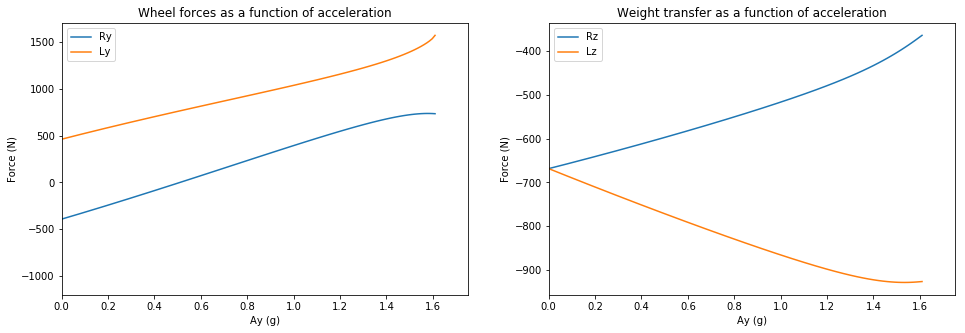

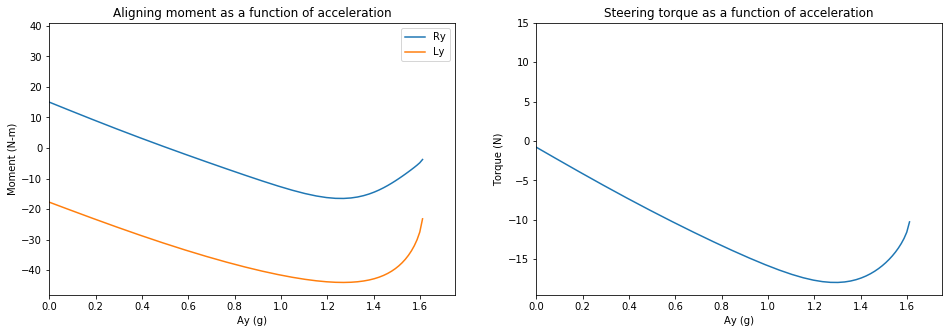

In [4]:
Frack = np.zeros(N, dtype='double')
FtireR = np.zeros((N, 6), dtype='double')
FtireL = np.zeros((N, 6), dtype='double')
for i in range(N):
    M = C.get_tire_moments(Fx[i], load[i], SA[i])
    FtireL[i, :2] = F[i][1]
    FtireL[i, 2] = load[i][1]
    FtireL[i, 5] = M[1][1]
    FtireR[i, :2] = F[i][0]
    FtireR[i, 2] = load[i][0]
    FtireR[i, 5] = M[0][1]
    PT = 12.7e-3
    PT = 6e-3
    AR = 76.2e-3
    Frack[i] = (-FtireL[i, 1]*PT - FtireR[i, 1]*PT + FtireL[i, 5] + FtireR[i, 5])/AR
    
    
# Pinion diameter is 
PD = 1.92e-2 # cm
TSW = PD*Frack

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(Ay, FtireR[:, 1], Ay, FtireL[:, 1])
plt.xlabel('Ay (g)')
plt.ylabel('Force (N)')
plt.title('Wheel forces as a function of acceleration')
plt.xlim(0, 1.75)
plt.legend(['Ry', 'Ly', 'Rx', 'Lx'])
plt.subplot(122)
plt.plot(Ay, FtireR[:, 2], Ay, FtireL[:, 2])
plt.xlabel('Ay (g)')
plt.ylabel('Force (N)')
plt.title('Weight transfer as a function of acceleration')
plt.xlim(0, 1.75)
plt.legend(['Rz', 'Lz'])
plt.show()

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(Ay, FtireR[:, 5], Ay, FtireL[:, 5])
plt.xlabel('Ay (g)')
plt.ylabel('Moment (N-m)')
plt.title('Aligning moment as a function of acceleration')
plt.xlim(0, 1.75)
plt.legend(['Ry', 'Ly', 'Rx', 'Lx'])
plt.subplot(122)
plt.plot(Ay, TSW)
plt.xlabel('Ay (g)')
plt.ylabel('Torque (N)')
plt.title('Steering torque as a function of acceleration')
plt.xlim(0, 1.75)
plt.show()